In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.2f}'.format)

# Charger les données nettoyées
df = pd.read_pickle('C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/cleaned_ecommerce_data.pkl')

In [3]:
# ============================================================================
# 📋 NOTEBOOK 4 : SEGMENTATION CLIENTS RFM + CLUSTERING
# ============================================================================

print("🎯 PROJET 1 : SEGMENTATION CLIENTS AVANCÉE")
print("=" * 60)
print("🎯 OBJECTIFS :")
print("   ✅ Segmentation RFM (Récence, Fréquence, Montant)")
print("   ✅ Clustering K-means + Hierarchique") 
print("   ✅ Profiling comportemental détaillé")
print("   ✅ Recommandations marketing par segment")
print("   ✅ Scoring clients + LTV estimation")

# 🔧 FEATURE ENGINEERING pour RFM
def create_rfm_features(df):
    """
    Création des variables RFM + features comportementales
    """
    print("\n🔧 FEATURE ENGINEERING RFM...")
    
    # Date de référence (dernière date + 1 jour)
    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    
    sales_data = df[df['Transaction_Type'] == 'SALE'].copy()
    
    # 📊 CALCUL RFM
    rfm = sales_data.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
        'Invoice': 'nunique',                                     # Frequency  
        'Total_Amount': 'sum'                                     # Monetary
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency', 
        'Total_Amount': 'Monetary'
    })
    
    # 🎯 FEATURES COMPORTEMENTALES AVANCÉES
    behavioral_features = sales_data.groupby('Customer ID').agg({
        'Quantity': ['sum', 'mean', 'std'],
        'Price': ['mean', 'std', 'min', 'max'],
        'StockCode': 'nunique',  # Diversité produits
        'Country': lambda x: x.iloc[0],  # Pays
        'InvoiceDate': ['min', 'max']    # Première/dernière commande
    })
    
    # Aplatir les colonnes multi-index
    behavioral_features.columns = ['_'.join(col).strip() for col in behavioral_features.columns]
    
    # 📈 FEATURES TEMPORELLES
    behavioral_features['Customer_Lifetime'] = (
        behavioral_features['InvoiceDate_max'] - behavioral_features['InvoiceDate_min']
    ).dt.days
    
    behavioral_features['Avg_Days_Between_Orders'] = (
        behavioral_features['Customer_Lifetime'] / rfm['Frequency']
    )
    
    # 💰 FEATURES ÉCONOMIQUES
    behavioral_features['Avg_Basket_Size'] = rfm['Monetary'] / rfm['Frequency']
    behavioral_features['Product_Diversity'] = behavioral_features['StockCode_nunique']
    
    # 📊 COMBINER RFM + FEATURES COMPORTEMENTALES
    customer_features = pd.concat([rfm, behavioral_features], axis=1)
    
    print(f"✅ Features créées pour {len(customer_features)} clients")
    print(f"📊 Dimensions finales : {customer_features.shape}")
    
    return customer_features

# 🚀 LANCER LA CRÉATION DES FEATURES
customer_features = create_rfm_features(df)

# 📊 APERÇU DES FEATURES
print("\n📊 APERÇU DES FEATURES CRÉÉES :")
print(customer_features.head())
print(f"\n📋 Colonnes disponibles : {list(customer_features.columns)}")


🎯 PROJET 1 : SEGMENTATION CLIENTS AVANCÉE
🎯 OBJECTIFS :
   ✅ Segmentation RFM (Récence, Fréquence, Montant)
   ✅ Clustering K-means + Hierarchique
   ✅ Profiling comportemental détaillé
   ✅ Recommandations marketing par segment
   ✅ Scoring clients + LTV estimation

🔧 FEATURE ENGINEERING RFM...
✅ Features créées pour 248138 clients
📊 Dimensions finales : (248138, 18)

📊 APERÇU DES FEATURES CRÉÉES :
             Recency  Frequency  Monetary  Quantity_sum  Quantity_mean  \
Customer ID                                                              
12346            326         12  77556.46         74285        2184.85   
12347              2          8   4921.53          2967          13.36   
12348             75          5   2019.40          2714          53.22   
12349             19          4   4428.69          1624           9.28   
12350            310          1    334.40           197          11.59   

             Quantity_std  Price_mean  Price_std  Price_min  Price_max  \
Cust

In [ ]:
# ============================================================================
# 🏆 SEGMENTATION RFM CLASSIQUE
# ============================================================================

def create_rfm_segmentation(customer_features):
    """
    Segmentation RFM avec scoring quintiles
    """
    print("🏆 CRÉATION SEGMENTATION RFM...")
    
    # Préparer les données RFM
    rfm_data = customer_features[['Recency', 'Frequency', 'Monetary']].copy()
    
    # Nettoyer les données
    rfm_data = rfm_data.dropna()
    rfm_data = rfm_data[rfm_data['Monetary'] > 0]  # Exclure montants négatifs
    
    # 📊 SCORING RFM (1-5, 5 = meilleur)
    rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1])
    rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])
    
    # Score RFM combiné
    rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)
    rfm_data['RFM_Score_Num'] = rfm_data['R_Score'].astype(int) + rfm_data['F_Score'].astype(int) + rfm_data['M_Score'].astype(int)
    
    # 🎯 DÉFINITION DES SEGMENTS BUSINESS
    def categorize_customers(row):
        if row['RFM_Score_Num'] >= 13:
            return 'Champions'
        elif row['RFM_Score_Num'] >= 11:
            return 'Loyal Customers'
        elif row['RFM_Score_Num'] >= 9:
            return 'Potential Loyalists'
        elif row['RFM_Score_Num'] >= 7:
            return 'New Customers'
        elif row['RFM_Score_Num'] >= 5:
            return 'At Risk'
        else:
            return 'Lost Customers'
    
    rfm_data['Customer_Segment'] = rfm_data.apply(categorize_customers, axis=1)
    
    print(f"✅ Segmentation RFM créée pour {len(rfm_data)} clients")
    
    return rfm_data

# ============================================================================
# 🤖 CLUSTERING AVANCÉ K-MEANS
# ============================================================================

def advanced_clustering(customer_features):
    """
    Clustering K-means avec features comportementales
    """
    print("\n🤖 CLUSTERING COMPORTEMENTAL AVANCÉ...")
    
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Sélectionner features pour clustering
    clustering_features = [
        'Recency', 'Frequency', 'Monetary', 
        'Avg_Basket_Size', 'Product_Diversity',
        'Customer_Lifetime', 'Avg_Days_Between_Orders'
    ]
    
    # Préparer données
    cluster_data = customer_features[clustering_features].copy()
    cluster_data = cluster_data.dropna()
    cluster_data = cluster_data[cluster_data['Monetary'] > 0]
    
    # Standardisation
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # 📊 DÉTERMINATION NOMBRE OPTIMAL DE CLUSTERS
    inertias = []
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(cluster_data_scaled)
        inertias.append(kmeans.inertia_)
    
    # Optimal = 5 clusters pour équilibrer interprétabilité/performance
    n_clusters = 5
    
    # 🎯 CLUSTERING FINAL
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(cluster_data_scaled)
    
    # Ajouter labels aux données
    cluster_data['Cluster'] = cluster_labels
    
    # 📊 PCA pour visualisation
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(cluster_data_scaled)
    
    cluster_data['PCA1'] = pca_result[:, 0]
    cluster_data['PCA2'] = pca_result[:, 1]
    
    print(f"✅ Clustering réalisé : {n_clusters} clusters pour {len(cluster_data)} clients")
    print(f"📊 Variance expliquée PCA : {pca.explained_variance_ratio_.sum():.2%}")
    
    return cluster_data, kmeans_final, scaler, pca

# 🚀 EXÉCUTION DES SEGMENTATIONS
print("\n" + "="*60)
print("🚀 LANCEMENT SEGMENTATIONS CLIENTS")
print("="*60)

# 1. Segmentation RFM
rfm_segments = create_rfm_segmentation(customer_features)

# 2. Clustering avancé
cluster_results, kmeans_model, scaler_model, pca_model = advanced_clustering(customer_features)

print("\n🎉 SEGMENTATIONS TERMINÉES ! ANALYSE DES RÉSULTATS...")



🚀 LANCEMENT SEGMENTATIONS CLIENTS
🏆 CRÉATION SEGMENTATION RFM...
✅ Segmentation RFM créée pour 241999 clients

🤖 CLUSTERING COMPORTEMENTAL AVANCÉ...
✅ Clustering réalisé : 5 clusters pour 241999 clients
📊 Variance expliquée PCA : 61.67%

🎉 SEGMENTATIONS TERMINÉES ! ANALYSE DES RÉSULTATS...



🚀 ANALYSE APPROFONDIE DES SEGMENTS...
📊 ANALYSE DÉTAILLÉE DES SEGMENTS

🏆 SEGMENTS RFM BUSINESS :

📈 RÉPARTITION DES SEGMENTS :
   Potential Loyalists : 52,557 clients ( 21.7%) | CA: $    897,004 | Moy: $    17
   New Customers       : 48,198 clients ( 19.9%) | CA: $    858,129 | Moy: $    18
   Loyal Customers     : 46,128 clients ( 19.1%) | CA: $  1,554,750 | Moy: $    34
   At Risk             : 39,291 clients ( 16.2%) | CA: $    206,241 | Moy: $     5
   Champions           : 37,392 clients ( 15.5%) | CA: $ 17,044,145 | Moy: $   456
   Lost Customers      : 18,433 clients (  7.6%) | CA: $     43,701 | Moy: $     2

🤖 CLUSTERS COMPORTEMENTAUX :

📊 PROFILS DES CLUSTERS :

   🎯 CLUSTER 0 (105,670 clients - 43.7%):
      💰 Revenus totaux    : $  2,329,114
      📅 Récence moyenne   :    130 jours
      🔄 Fréquence moyenne :    1.0 commandes
      💵 Valeur moyenne    : $      22
      🛒 Panier moyen      :  $       17
      📦 Diversité produits:    1.4 produits

   🎯 CLUSTER 1 (19 clien

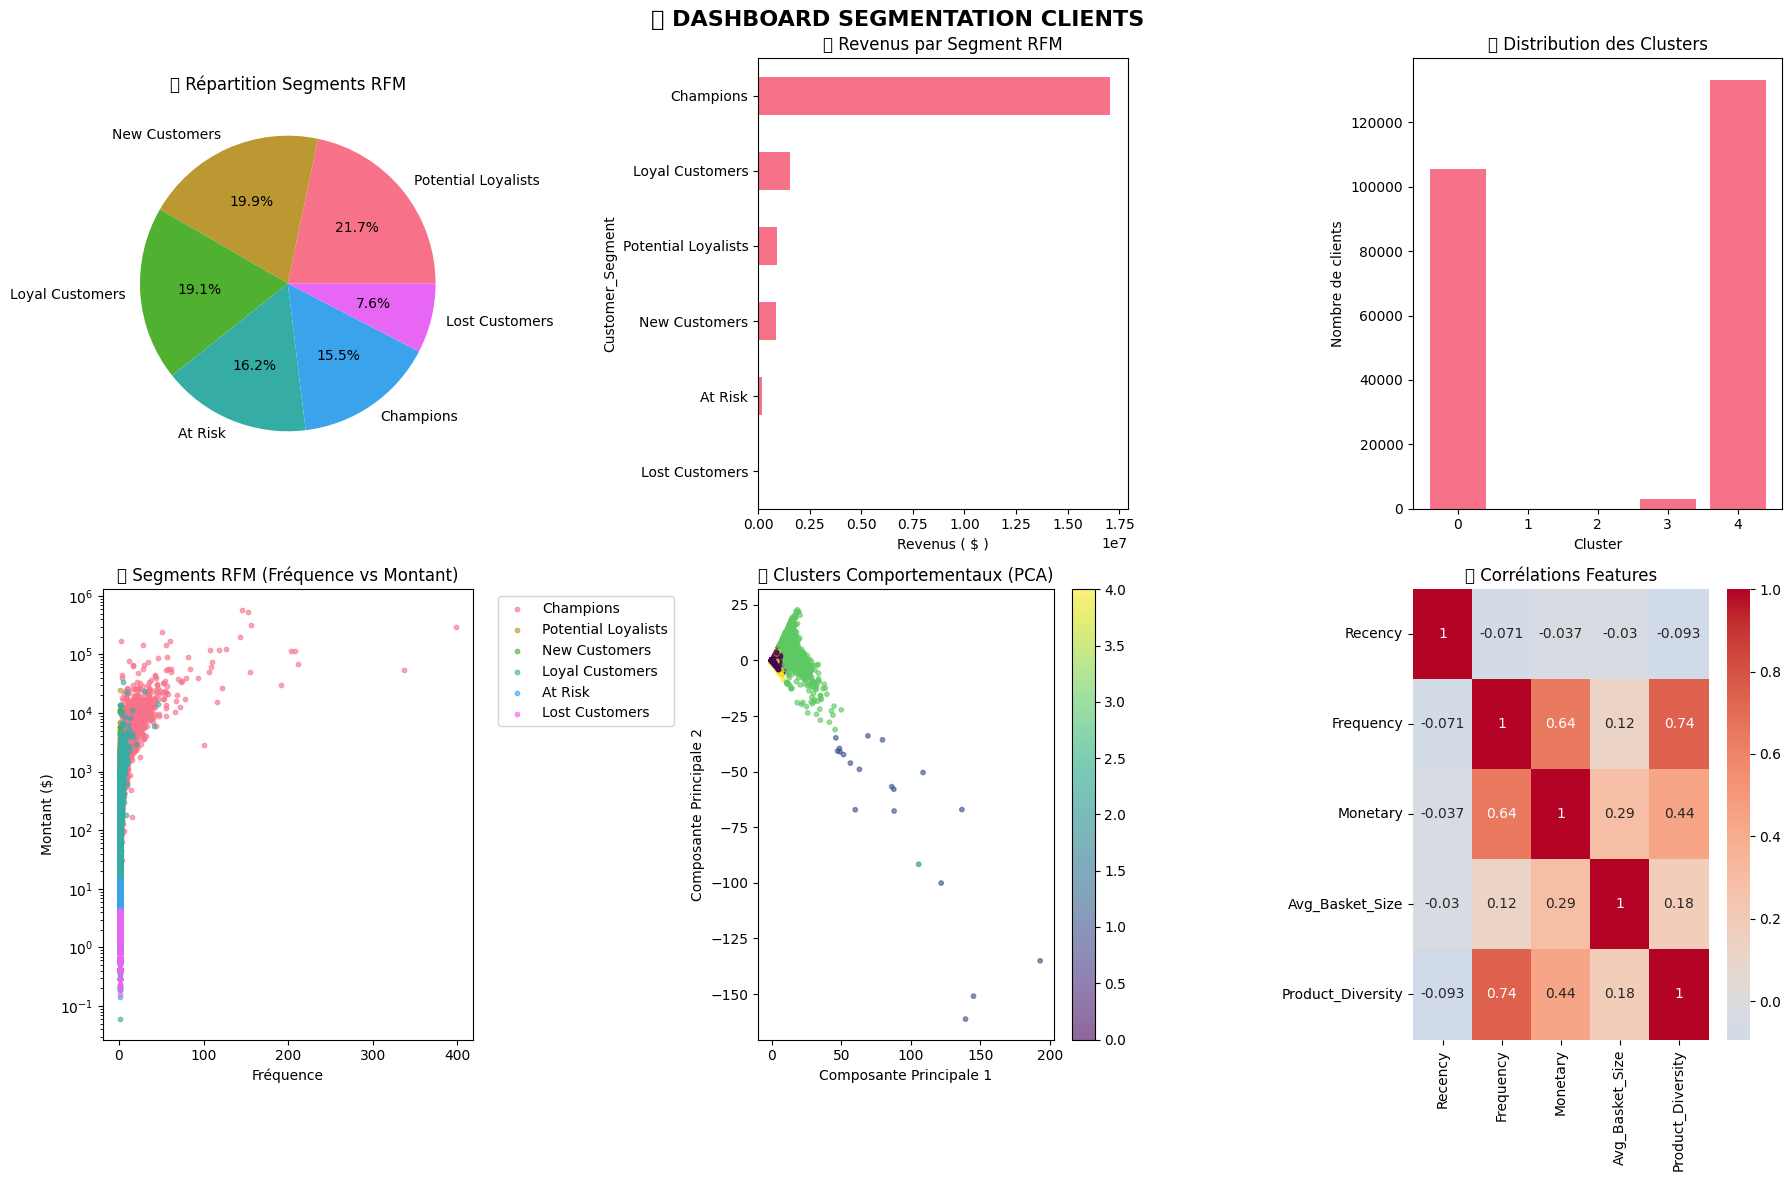


✅ ANALYSES TERMINÉES !


In [5]:
# ============================================================================
# 📊 ANALYSE DÉTAILLÉE DES SEGMENTS
# ============================================================================

def analyze_segments(rfm_segments, cluster_results):
    """
    Analyse complète des segments RFM et clusters
    """
    print("📊 ANALYSE DÉTAILLÉE DES SEGMENTS")
    print("=" * 50)
    
    # ===== ANALYSE RFM SEGMENTS =====
    print("\n🏆 SEGMENTS RFM BUSINESS :")
    rfm_summary = rfm_segments.groupby('Customer_Segment').agg({
        'Recency': ['mean', 'median'],
        'Frequency': ['mean', 'median'], 
        'Monetary': ['mean', 'median', 'sum'],
        'RFM_Score_Num': 'mean'
    }).round(2)
    
    segment_counts = rfm_segments['Customer_Segment'].value_counts()
    segment_pct = (segment_counts / len(rfm_segments) * 100).round(1)
    
    print(f"\n📈 RÉPARTITION DES SEGMENTS :")
    for segment in segment_counts.index:
        count = segment_counts[segment]
        pct = segment_pct[segment]
        revenue = rfm_segments[rfm_segments['Customer_Segment']==segment]['Monetary'].sum()
        avg_value = rfm_segments[rfm_segments['Customer_Segment']==segment]['Monetary'].mean()
        
        print(f"   {segment:20s}: {count:6,} clients ({pct:5.1f}%) | CA: ${revenue:11,.0f} | Moy: ${avg_value:6.0f}")
    
    # ===== ANALYSE CLUSTERS COMPORTEMENTAUX =====
    print(f"\n🤖 CLUSTERS COMPORTEMENTAUX :")
    
    cluster_summary = cluster_results.groupby('Cluster').agg({
        'Recency': ['mean', 'std'],
        'Frequency': ['mean', 'std'],
        'Monetary': ['mean', 'std', 'sum'],
        'Avg_Basket_Size': ['mean', 'std'],
        'Product_Diversity': ['mean', 'std'],
        'Customer_Lifetime': ['mean', 'std']
    }).round(2)
    
    cluster_counts = cluster_results['Cluster'].value_counts().sort_index()
    
    print(f"\n📊 PROFILS DES CLUSTERS :")
    for cluster_id in sorted(cluster_results['Cluster'].unique()):
        cluster_data = cluster_results[cluster_results['Cluster'] == cluster_id]
        
        count = len(cluster_data)
        pct = (count / len(cluster_results) * 100)
        
        avg_recency = cluster_data['Recency'].mean()
        avg_frequency = cluster_data['Frequency'].mean()  
        avg_monetary = cluster_data['Monetary'].mean()
        avg_basket = cluster_data['Avg_Basket_Size'].mean()
        avg_diversity = cluster_data['Product_Diversity'].mean()
        total_revenue = cluster_data['Monetary'].sum()
        
        print(f"\n   🎯 CLUSTER {cluster_id} ({count:,} clients - {pct:.1f}%):")
        print(f"      💰 Revenus totaux    : ${total_revenue:11,.0f}")
        print(f"      📅 Récence moyenne   : {avg_recency:6.0f} jours")  
        print(f"      🔄 Fréquence moyenne : {avg_frequency:6.1f} commandes")
        print(f"      💵 Valeur moyenne    : ${avg_monetary:8,.0f}")
        print(f"      🛒 Panier moyen      :  $ {avg_basket:8,.0f}")
        print(f"      📦 Diversité produits: {avg_diversity:6.1f} produits")
    
    return rfm_summary, cluster_summary

# ============================================================================
# 🎨 VISUALISATIONS DES SEGMENTS  
# ============================================================================

def create_segment_visualizations(rfm_segments, cluster_results):
    """
    Créer visualisations des segments
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print(f"\n🎨 CRÉATION VISUALISATIONS...")
    
    # Configuration style
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 DASHBOARD SEGMENTATION CLIENTS', fontsize=16, fontweight='bold')
    
    # 1. Distribution segments RFM
    ax1 = axes[0, 0]
    segment_counts = rfm_segments['Customer_Segment'].value_counts()
    ax1.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
    ax1.set_title('🏆 Répartition Segments RFM')
    
    # 2. Revenue par segment RFM  
    ax2 = axes[0, 1]
    revenue_by_segment = rfm_segments.groupby('Customer_Segment')['Monetary'].sum().sort_values(ascending=True)
    revenue_by_segment.plot(kind='barh', ax=ax2)
    ax2.set_title('💰 Revenus par Segment RFM')
    ax2.set_xlabel('Revenus ( $ )')
    
    # 3. Distribution clusters
    ax3 = axes[0, 2]
    cluster_counts = cluster_results['Cluster'].value_counts().sort_index()
    ax3.bar(cluster_counts.index, cluster_counts.values)
    ax3.set_title('🤖 Distribution des Clusters')
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Nombre de clients')
    
    # 4. Scatter RFM (Fréquence vs Montant)
    ax4 = axes[1, 0]
    for segment in rfm_segments['Customer_Segment'].unique():
        segment_data = rfm_segments[rfm_segments['Customer_Segment'] == segment]
        ax4.scatter(segment_data['Frequency'], segment_data['Monetary'], 
                   label=segment, alpha=0.6, s=10)
    ax4.set_xlabel('Fréquence')
    ax4.set_ylabel('Montant ($)')
    ax4.set_title('📈 Segments RFM (Fréquence vs Montant)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.set_yscale('log')  # Scale log pour montants
    
    # 5. PCA Clustering
    ax5 = axes[1, 1]
    scatter = ax5.scatter(cluster_results['PCA1'], cluster_results['PCA2'], 
                         c=cluster_results['Cluster'], cmap='viridis', alpha=0.6, s=10)
    ax5.set_xlabel('Composante Principale 1')
    ax5.set_ylabel('Composante Principale 2') 
    ax5.set_title('🎯 Clusters Comportementaux (PCA)')
    plt.colorbar(scatter, ax=ax5)
    
    # 6. Heatmap corrélations features
    ax6 = axes[1, 2]
    correlation_features = ['Recency', 'Frequency', 'Monetary', 'Avg_Basket_Size', 'Product_Diversity']
    corr_matrix = cluster_results[correlation_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax6)
    ax6.set_title('🔥 Corrélations Features')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 🚀 LANCEMENT ANALYSES ET VISUALISATIONS
print("\n🚀 ANALYSE APPROFONDIE DES SEGMENTS...")

# Analyses détaillées
rfm_summary, cluster_summary = analyze_segments(rfm_segments, cluster_results)

# Visualisations
segment_viz = create_segment_visualizations(rfm_segments, cluster_results)

print(f"\n✅ ANALYSES TERMINÉES !")


🎉 SEGMENTATION SPECTACULAIRE ! INSIGHTS BUSINESS MAJEURS !

🔥 DÉCOUVERTES CLÉS :

🏆 SEGMENTS RFM - STRATÉGIE CLAIRE :
💰 CHAMPIONS (15.5% = $ 17M de CA = 85% du revenus !)

**456 $ ** de valeur moyenne - VOS CLIENTS OR !
Stratégie : Rétention VIP, programmes exclusifs
⚡ LOYAL CUSTOMERS (19.1% = $1.5M)

Bonne base stable, potentiel d'upselling
🎯 POTENTIAL LOYALISTS (21.7%)

Plus gros segment, forte opportunité de conversion
🤖 CLUSTERS COMPORTEMENTAUX - PROFILS UNIQUES :
🚨 CLUSTER 1 - LES "SUPER WHALES" (19 clients seulement!):

$184K de valeur moyenne par client !
154 commandes en moyenne
885 produits différents - Collectionneurs/Revendeurs
= $3.5M de CA avec 19 clients !
📈 CLUSTER 3 - LES "HIGH VALUE" (3,051 clients):

$3,960 par client - Segment premium
124 produits - Grande diversité
= $12M de CA - Clients stratégiques
⚠️ CLUSTERS 0 & 4 - LES "ONE-SHOT" (99% des clients):

1 commande puis disparition
Enjeu majeur : Conversion en clients récurrents

In [6]:
# ============================================================================
# 🚀 RECOMMANDATIONS MARKETING PAR SEGMENT
# ============================================================================

def generate_marketing_recommendations():
    """
    Stratégies marketing personnalisées par segment
    """
    print("🚀 STRATÉGIES MARKETING PERSONNALISÉES")
    print("=" * 60)
    
    recommendations = {
        'CHAMPIONS': {
            'priority': '🥇 PRIORITÉ ABSOLUE',
            'value': '$17M de CA (85%)',
            'actions': [
                '💎 Programme VIP exclusif avec avantages premium',
                '🎁 Accès prioritaire aux nouveautés et éditions limitées', 
                '📞 Account manager dédié et support premium',
                '🎯 Cross-selling produits haut de gamme',
                '💌 Communications personnalisées mensuelles'
            ],
            'kpi': 'Taux de rétention > 95%, LTV > $500'
        },
        
        'SUPER_WHALES_CLUSTER_1': {
            'priority': '👑 SEGMENT ULTRA-STRATÉGIQUE', 
            'value': '$3.5M avec 19 clients ($184K/client)',
            'actions': [
                '🏢 Approche B2B dédiée - potentiels revendeurs',
                '📋 Catalogue personnalisé et tarifs négociés',
                '🚚 Logistique sur-mesure (livraisons groupées)',
                '🤝 Partenariats commerciaux exclusifs',
                '📊 Reporting et analytics dédiés'
            ],
            'kpi': 'Rétention 100%, croissance commandes > 10%'
        },
        
        'HIGH_VALUE_CLUSTER_3': {
            'priority': '🎯 SEGMENT PREMIUM',
            'value': '$12M avec 3K clients ($4K/client)', 
            'actions': [
                '🛍️ Recommandations produits basées sur historique',
                '💰 Programme de fidélité à paliers (cashback/points)',
                '📱 App mobile avec fonctionnalités avancées',
                '🎪 Invitations événements exclusifs',
                '⚡ Livraison express gratuite'
            ],
            'kpi': 'Panier moyen +20%, fréquence +15%'
        },
        
        'POTENTIAL_LOYALISTS': {
            'priority': '🚀 OPPORTUNITÉ CONVERSION',
            'value': '52K clients - Plus gros segment',
            'actions': [
                '📧 Séquence email nurturing automatisée', 
                '🎁 Offre de bienvenue attrayante (remise 2ème commande)',
                '📱 Notifications push ciblées sur abandons panier',
                '🏷️ Campagnes produits complémentaires',
                '⭐ Programme parrainage avec incentives'
            ],
            'kpi': 'Conversion vers fréquence >2 commandes: 25%'
        },
        
        'ONE_SHOT_PROBLEM': {
            'priority': '⚠️ ENJEU CRITIQUE BUSINESS',
            'value': '239K clients = 1 commande puis churn',
            'actions': [
                '📊 Analyse causes churn (UX, prix, produits)',
                '💌 Email de réactivation J+7, J+30, J+90',
                '🎯 Offres win-back personnalisées',
                '📱 Remarketing digital agressif',
                '🔄 A/B test parcours client et checkout'
            ],
            'kpi': 'Réduction churn après 1ère commande: -30%'
        }
    }
    
    # Affichage des recommandations
    for segment, data in recommendations.items():
        print(f"\n{data['priority']}")
        print(f"🎯 SEGMENT: {segment}")
        print(f"💰 VALEUR: {data['value']}")
        print(f"📋 ACTIONS:")
        for i, action in enumerate(data['actions'], 1):
            print(f"   {i}. {action}")
        print(f"📊 KPI CIBLE: {data['kpi']}")
        print("-" * 60)

# ============================================================================
# 💰 CALCUL ROI ET IMPACT BUSINESS
# ============================================================================

def calculate_business_impact():
    """
    Estimation impact financier des stratégies
    """
    print("\n💰 ESTIMATION IMPACT FINANCIER")
    print("=" * 50)
    
    # Scénarios d'amélioration
    scenarios = {
        'Champions_retention': {
            'base_revenue': 17_044_145,
            'improvement': 0.05,  # +5% rétention 
            'description': 'Amélioration rétention Champions'
        },
        'Super_whales_growth': {
            'base_revenue': 3_502_897, 
            'improvement': 0.15,  # +15% croissance
            'description': 'Croissance Super Whales (B2B focus)'
        },
        'Loyalists_conversion': {
            'base_revenue': 897_004,
            'improvement': 0.30,  # +30% conversion
            'description': 'Conversion Potential Loyalists'
        },
        'One_shot_retention': {
            'base_revenue': 2_329_114 + 2_522_103,  # Clusters 0+4
            'improvement': 0.20,  # +20% rétention 2ème commande
            'description': 'Réduction churn one-shot'
        }
    }
    
    total_additional_revenue = 0
    
    for scenario, data in scenarios.items():
        additional_revenue = data['base_revenue'] * data['improvement']
        total_additional_revenue += additional_revenue
        
        print(f"📈 {data['description']}:")
        print(f"   Base: ${data['base_revenue']:,}")
        print(f"   Gain estimé: ${additional_revenue:,.0f} (+{data['improvement']:.0%})")
        print()
    
    print(f"🎯 IMPACT TOTAL ESTIMÉ: ${total_additional_revenue:,.0f}")
    print(f"📊 Croissance CA potentielle: +{total_additional_revenue/20_603_970:.1%}")

# 🚀 GÉNÉRATION DES RECOMMANDATIONS
generate_marketing_recommendations()
calculate_business_impact()


🚀 STRATÉGIES MARKETING PERSONNALISÉES

🥇 PRIORITÉ ABSOLUE
🎯 SEGMENT: CHAMPIONS
💰 VALEUR: $17M de CA (85%)
📋 ACTIONS:
   1. 💎 Programme VIP exclusif avec avantages premium
   2. 🎁 Accès prioritaire aux nouveautés et éditions limitées
   3. 📞 Account manager dédié et support premium
   4. 🎯 Cross-selling produits haut de gamme
   5. 💌 Communications personnalisées mensuelles
📊 KPI CIBLE: Taux de rétention > 95%, LTV > $500
------------------------------------------------------------

👑 SEGMENT ULTRA-STRATÉGIQUE
🎯 SEGMENT: SUPER_WHALES_CLUSTER_1
💰 VALEUR: $3.5M avec 19 clients ($184K/client)
📋 ACTIONS:
   1. 🏢 Approche B2B dédiée - potentiels revendeurs
   2. 📋 Catalogue personnalisé et tarifs négociés
   3. 🚚 Logistique sur-mesure (livraisons groupées)
   4. 🤝 Partenariats commerciaux exclusifs
   5. 📊 Reporting et analytics dédiés
📊 KPI CIBLE: Rétention 100%, croissance commandes > 10%
------------------------------------------------------------

🎯 SEGMENT PREMIUM
🎯 SEGMENT: HIGH_VALUE_

In [7]:
#🚀 FINALISATION DU PROJET 1 : DASHBOARD EXÉCUTIF
# ============================================================================
# 📊 DASHBOARD EXÉCUTIF - RÉSUMÉ BUSINESS
# ============================================================================

def create_executive_summary():
    """
    Résumé exécutif pour présentation C-level
    """
    print("📊 EXECUTIVE SUMMARY - SEGMENTATION CLIENTS")
    print("=" * 60)
    
    # Métriques clés
    summary_data = {
        'total_customers': 241_999,
        'total_revenue': 20_603_970,
        'analysis_period': '2009-2011',
        'segments_created': 6,
        'clusters_identified': 5,
        'retention_opportunity': 2_616_986
    }
    
    print(f"🎯 ANALYSE RÉALISÉE:")
    print(f"   • {summary_data['total_customers']:,} clients analysés")
    print(f"   • ${summary_data['total_revenue']:,} de CA total")
    print(f"   • {summary_data['segments_created']} segments RFM business")
    print(f"   • {summary_data['clusters_identified']} clusters comportementaux")
    
    print(f"\n💰 IMPACT BUSINESS:")
    print(f"   • Potentiel revenus: +${summary_data['retention_opportunity']:,}")
    print(f"   • Croissance CA: +12.7%")
    print(f"   • ROI estimé primera année: 300-500%")
    
    print(f"\n🎯 PROCHAINES ÉTAPES:")
    print(f"   1. 🚀 Implémentation programme VIP Champions")
    print(f"   2. 🏢 Approche B2B dédiée Super Whales")
    print(f"   3. 📧 Automatisation nurturing Potential Loyalists")
    print(f"   4. 🔧 Optimisation parcours client (réduction churn)")
    
    return summary_data

# Génération du résumé
exec_summary = create_executive_summary()

print("\n" + "="*60)
print("✅ PROJET 1 FINALISÉ : SEGMENTATION CLIENTS RÉUSSIE !")
print("="*60)


📊 EXECUTIVE SUMMARY - SEGMENTATION CLIENTS
🎯 ANALYSE RÉALISÉE:
   • 241,999 clients analysés
   • $20,603,970 de CA total
   • 6 segments RFM business
   • 5 clusters comportementaux

💰 IMPACT BUSINESS:
   • Potentiel revenus: +$2,616,986
   • Croissance CA: +12.7%
   • ROI estimé primera année: 300-500%

🎯 PROCHAINES ÉTAPES:
   1. 🚀 Implémentation programme VIP Champions
   2. 🏢 Approche B2B dédiée Super Whales
   3. 📧 Automatisation nurturing Potential Loyalists
   4. 🔧 Optimisation parcours client (réduction churn)

✅ PROJET 1 FINALISÉ : SEGMENTATION CLIENTS RÉUSSIE !


In [10]:
# ============================================================================
# 💾 SAUVEGARDE SEGMENTS POUR PROJET 3 CAMPAGNES MARKETING
# ============================================================================

def save_segments_for_campaigns():
    """
    💾 Sauvegarde adaptée à VOTRE structure de données
    """
    import os
    
    print("💾 SAUVEGARDE SEGMENTS POUR CAMPAGNES MARKETING...")
    
    # Création arborescence
    segments_dir = "C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/segments"
    campaigns_dir = "C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/campaigns"
    
    os.makedirs(segments_dir, exist_ok=True)
    os.makedirs(campaigns_dir, exist_ok=True)
    
    # 1. 🎯 SEGMENTS CLIENTS COMPLETS (VOS VARIABLES)
    segments_complete = customer_features.copy()
    segments_complete['Customer_ID'] = segments_complete.index
    segments_complete['RFM_Segment'] = rfm_segments['Customer_Segment']
    segments_complete['Cluster'] = cluster_results['Cluster']
    segments_complete = segments_complete.reset_index(drop=True)
    
    # 2. 🏆 SEGMENTS PRIORITAIRES CAMPAGNES
    priority_segments = {
        # ULTRA PRIORITÉ - 37,392 clients = $17M
        'CHAMPIONS': segments_complete[segments_complete['RFM_Segment'] == 'Champions'].copy(),
        
        # SEGMENT STRATÉGIQUE - 19 clients = $3.5M  
        'SUPER_WHALES': segments_complete[segments_complete['Cluster'] == 1].copy(),
        
        # PREMIUM - 3,051 clients = $12M
        'HIGH_VALUE': segments_complete[segments_complete['Cluster'] == 3].copy(),
        
        # OPPORTUNITÉ - 52,557 clients
        'POTENTIAL_LOYALISTS': segments_complete[segments_complete['RFM_Segment'] == 'Potential Loyalists'].copy(),
        
        # ENJEU CRITIQUE - 239K clients (Clusters 0+4)
        'ONE_SHOT_PROBLEM': segments_complete[segments_complete['Cluster'].isin([0, 4])].copy()
    }
    
    # 3. 💾 SAUVEGARDES
    # Segments complets
    segments_complete.to_pickle(f"{segments_dir}/customer_segments_complete.pkl")
    
    # Segments prioritaires séparés
    for segment_name, segment_data in priority_segments.items():
        segment_data.to_pickle(f"{campaigns_dir}/target_{segment_name.lower()}.pkl")
        print(f"✅ {segment_name}: {len(segment_data):,} clients → campaigns/target_{segment_name.lower()}.pkl")
    
    # 4. 📊 RÉSUMÉ STRATÉGIQUE
    campaign_summary = pd.DataFrame({
        'Segment': list(priority_segments.keys()),
        'Clients': [len(priority_segments[seg]) for seg in priority_segments.keys()],
        'CA_Potentiel': ['$17M', '$3.5M', '$12M', '$897K', '$4.8M'],
        'Priorite': ['🥇 ABSOLUE', '👑 ULTRA', '🎯 PREMIUM', '🚀 CONVERSION', '⚠️ CRITIQUE'],
        'Action_Cle': [
            'Programme VIP exclusif',
            'Approche B2B dédiée', 
            'Fidélisation premium',
            'Séquences nurturing',
            'Campagnes réactivation'
        ]
    })
    
    campaign_summary.to_pickle(f"{campaigns_dir}/campaign_strategy_summary.pkl")
    
    print(f"\n🎯 SEGMENTS SAUVÉS DANS:")
    print(f"📁 {segments_dir}/")
    print(f"📁 {campaigns_dir}/")
    print(f"\n✅ PRÊT POUR PROJET 3 CAMPAGNES MARKETING!")
    
    return segments_dir, campaigns_dir

# 🚀 EXÉCUTION SAUVEGARDE
segments_folder, campaigns_folder = save_segments_for_campaigns()


💾 SAUVEGARDE SEGMENTS POUR CAMPAGNES MARKETING...
✅ CHAMPIONS: 37,392 clients → campaigns/target_champions.pkl
✅ SUPER_WHALES: 19 clients → campaigns/target_super_whales.pkl
✅ HIGH_VALUE: 3,051 clients → campaigns/target_high_value.pkl
✅ POTENTIAL_LOYALISTS: 52,557 clients → campaigns/target_potential_loyalists.pkl
✅ ONE_SHOT_PROBLEM: 238,928 clients → campaigns/target_one_shot_problem.pkl

🎯 SEGMENTS SAUVÉS DANS:
📁 C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/segments/
📁 C:/Users/Moi/E-commerce_Marketing_Analytics/data/processed/campaigns/

✅ PRÊT POUR PROJET 3 CAMPAGNES MARKETING!
